In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

sheet_name = 'Report Data'
features = {
    'time' : '5 Minutes',
    'flow' : 'Flow (Veh/5 Minutes)',
    'speed' : 'Speed (mph)'
}
cols = [features[x] for x in features]
num_parts = 4


for i in range(0, num_parts):
    file_in = '../data/pems_output_' + str(i) + '.xlsx'
    file_out = '../data/pems_' + str(i) + '.csv'
    df = pd.read_excel(file_in, sheet_name)
    dataset = df[cols]
    dataset.to_csv(file_out, index=False)

In [2]:
for i in range(num_parts):
    df = pd.read_csv('../data/pems_' + str(i) + '.csv')
    print(df.head(1))

   Flow (Veh/5 Minutes)       5 Minutes  Speed (mph)
0                    87  3/01/2018 0:00         68.3
   Flow (Veh/5 Minutes)       5 Minutes  Speed (mph)
0                   129  3/08/2018 0:00         68.5
   Flow (Veh/5 Minutes)       5 Minutes  Speed (mph)
0                    91  3/15/2018 0:00         68.7
   Flow (Veh/5 Minutes)       5 Minutes  Speed (mph)
0                    93  3/22/2018 0:00         68.6


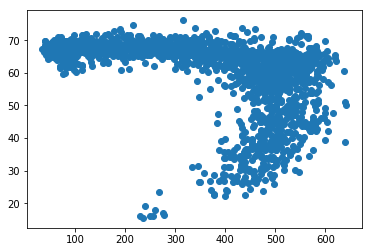

In [15]:
import matplotlib.pyplot as plt
df = pd.read_csv('../data/pems_0.csv')
plt.scatter(df[features['flow']], df[features['speed']])
plt.show()

In [4]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)


In [5]:
# Scale the flow, keep speed the same
feature_range = (0,1)
data_min = np.min(train[features['flow']], axis=0)
data_max = np.max(train[features['flow']], axis=0)
data_range = data_max - data_min

scale_ = ((feature_range[1] - feature_range[0])/data_range)
min_ = feature_range[0]-data_min*scale_

flow_train = train[features['flow']]
flow_train *= scale_
flow_train += min_

flow_test = test[features['flow']]
flow_test *= scale_
flow_test += min_

train_list, test_list = [], []
lag = 12

for i in range(lag, len(flow_train)-1):
    xi_flow = flow_train[i-lag:i+1]
    xi_speed = train[features['speed']][i-lag:i+1]
    train_list.append((xi_flow, xi_speed))
for i in range(lag, len(flow_test)-1):
    xi_flow = flow_test[i-lag:i+1]
    xi_speed = test[features['speed']][i-lag:i+1]
    test_list.append((xi_flow, xi_speed))

train_list = np.asarray(train_list)
test_list = np.asarray(test_list)

X_train = train_list[:, :, :-1]
y_train = train_list[:, :, -1]
X_test = test_list[:, :, :-1]
y_test = test_list[:, :, -1]

scaler = (scale_, min_)
print(scaler)

(0.001644736842105263, -0.05592105263157894)


In [6]:
print(X_train.shape)
print(X_train[1])

(1609, 2, 12)
[[1.26644737e-01 8.05921053e-02 1.54605263e-01 1.06907895e-01
  1.23355263e-01 6.08552632e-02 4.76973684e-02 4.60526316e-02
  6.41447368e-02 2.79605263e-02 4.11184211e-02 3.78289474e-02]
 [6.87000000e+01 6.97000000e+01 6.99000000e+01 6.91000000e+01
  6.76000000e+01 6.72000000e+01 6.90000000e+01 6.72000000e+01
  6.81000000e+01 6.82000000e+01 6.87000000e+01 6.68000000e+01]]


In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2], 1))

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten

model = Sequential()
model.add(LSTM(256, input_shape=(24, 1), return_sequences=True, recurrent_initializer='glorot_uniform', kernel_initializer='glorot_uniform'))
model.add(LSTM(256, recurrent_initializer='glorot_uniform', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='relu', kernel_initializer='glorot_uniform'))
model.compile(loss='mse', optimizer='rmsprop', metrics=['mape'])
model.summary()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 256)           264192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 790,018
Trainable params: 790,018
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
1609/1609 [==============================] - 5s 3ms/step - loss: 722.7093 - mean_absolute_percentage_error: 106.6596
Epoch 2/100
1609/1609 [==============================] - 3s 2ms/step - loss: 325.1006 - mean_absolute_percentage_error: 82.1103
Epoch 3/100
1609/1609 [==============================] - 3s 2ms/step - loss: 142.4778 - mean_absolute_percentage_error: 74.4180
Epoch 4/100
1609/1609 [==============================] - 3s 2ms/step - loss: 34.9622 - mean_absolute_percentage_error: 120359.9203
Epoch 5/100
1609/1609 [==============================] - 3s 2ms/step - loss: 15.7957 - mean_absolute_percentage_error: 61.6264
Epoch 6/100
1609/1609 [==============================] - 3s 2ms/step - loss: 13.0147 - mean_absolute_percentage_error: 60.0704
Epoch 7/100
1609/1609 [==============================] - 3s 2ms/step - loss: 11.7938 - mean_absolute_percentage_error: 59.5625
Epoch 8/100
1609/1609 [==============================] - 3s 2ms/step - loss: 13.0961 - mean_absolute_pe

Epoch 64/100
1609/1609 [==============================] - 3s 2ms/step - loss: 9.0891 - mean_absolute_percentage_error: 58816.9326
Epoch 65/100
1609/1609 [==============================] - 3s 2ms/step - loss: 8.8853 - mean_absolute_percentage_error: 80849.9552
Epoch 66/100
1609/1609 [==============================] - 3s 2ms/step - loss: 9.0397 - mean_absolute_percentage_error: 42241.7334
Epoch 67/100
1609/1609 [==============================] - 3s 2ms/step - loss: 9.9445 - mean_absolute_percentage_error: 33111.6312
Epoch 68/100
1609/1609 [==============================] - 3s 2ms/step - loss: 8.9870 - mean_absolute_percentage_error: 88629.5114
Epoch 69/100
1609/1609 [==============================] - 3s 2ms/step - loss: 9.5208 - mean_absolute_percentage_error: 51140.6469
Epoch 70/100
1609/1609 [==============================] - 3s 2ms/step - loss: 9.1138 - mean_absolute_percentage_error: 62315.4764
Epoch 71/100
1609/1609 [==============================] - 3s 2ms/step - loss: 9.1918 - mea

In [10]:
score = model.evaluate(X_test, y_test, batch_size=32)

393/393 [==============================] - 0s 957us/step


In [11]:
print(score)

[7.753191358260526, 48.14723322045712]


In [12]:
x_hat = X_test
preds = model.predict(x_hat)

In [13]:
print(preds[0])

[ 0.80856895 52.86869   ]


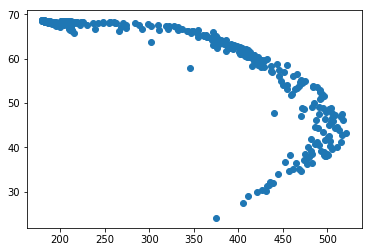

In [14]:
flows = [(x[0]/scale_ + min_) for x in preds]
speeds = [x[1] for x in preds]
plt.scatter(flows, speeds)
plt.show()